In [50]:
#
# Created on Fri Nov 24 2023 00:57:09
# Author: Mukai (Tom Notch) Yu
# Email: myual@connect.ust.hk
# Affiliation: Hong Kong University of Science and Technology
#
# Copyright Ⓒ 2023 Mukai (Tom Notch) Yu
#
import cv2
import numpy as np
import torch
import os
from abc import ABC, abstractmethod
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

from utils.files import read_file, print_dict
from dataloader.feature_extractor import FeatureExtractor
from dataloader.perspective_warper import PerspectiveWarper
from dataloader.visualization import visualize_keypoints, visualize_matches

In [51]:
config = read_file("./configs/default.yaml")
print_dict(config)

train: 
  epochs: 10.0
  learning_rate: 0.0001
  dataset: 
    batch_size: 32.0
    COCO: 
      path: ./COCO2014/train2014
      fraction: 0.001
      resize: [640.0, 480.0]
      fix_warp: false
      shuffle: true
    ScanNet: 
      path: ./ScanNet/train
      fraction: 0.001
      resize: [640.0, 480.0]
      fix_warp: false
      shuffle: true
eval: 
  output_dir: ./dump_match_pairs/
  eval_interval: 5.0
  dataset: 
    batch_size: 32.0
    COCO: 
      path: ./COCO2014/eval2014
      fraction: 0.001
      resize: [640.0, 480.0]
      fix_warp: true
      shuffle: true
    ScanNet: 
      path: ./ScanNet/eval
      fraction: 0.001
      resize: [640.0, 480.0]
      fix_warp: true
      shuffle: true
superglue: 
  num_layers: 3.0
  sinkhorn_iterations: 10.0
  match_threshold: 0.2
  descriptor_dim: 256.0
feature_extraction: 
  max_keypoints: 1024.0
  descriptor_dim: 256.0
  extractor: 
    SIFT: 
      contrast_threshold: 0.04
      edge_threshold: 10.0
      sigma: 1.6
perspective

In [52]:
class COCODataset(Dataset):
    def __init__(self, config: dict, feature_extractor, perspective_warper):
        self.config = config
        self.path = config["path"]
        self.fraction = config["fraction"]
        self.resize = [int(dim) for dim in config["resize"]]
        self.fix_warp = config["fix_warp"]
        self.shuffle = config["shuffle"]

        self.feature_extractor = feature_extractor
        self.perspective_warper = perspective_warper

        self.files = []
        # recursively walk though the directory
        for root, _, files in os.walk(self.path):
            for file in files:
                if file.endswith(".jpg") or file.endswith(".png"):
                    self.files.append(os.path.join(root, file))

        # limit the number of files to self.fraction x total number of files
        self.files = self.files[: int(len(self.files) * self.fraction)]

        if self.fix_warp:
            self.transforms = [
                self.perspective_warper.generate_transform(*self.resize)
                for _ in range(len(self.files))
            ]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index: int):
        file = self.files[index]
        image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        if self.resize is not None:
            image = cv2.resize(image, self.resize)

        width, height = image.shape

        # Retrieve or generate transform
        transform = (
            self.transforms[index]
            if self.fix_warp
            else self.perspective_warper.generate_transform(width, height)
        )

        # Apply transform
        image_novel = self.perspective_warper.warp_image_to_novel(image, transform)

        (
            keypoints_original,
            descriptors_original,
            confidence_score_original,
        ) = self.feature_extractor(image)
        (
            keypoints_novel,
            descriptors_novel,
            confidence_score_novel,
        ) = self.feature_extractor(image_novel)

        keypoints_original_warped_to_novel = (
            self.perspective_warper.warp_keypoints_to_novel(
                keypoints_original, transform
            )
        )
        keypoints_novel_warped_to_original = (
            self.perspective_warper.warp_keypoints_to_original(
                keypoints_novel, transform
            )
        )

        # Compute distances between warped original keypoints and keypoints from the novel image
        dists_original_to_novel = torch.cdist(
            keypoints_original_warped_to_novel, keypoints_novel
        )
        dists_novel_to_original = torch.cdist(
            keypoints_original, keypoints_novel_warped_to_original
        )

        # run linear_sum_assignment to find mutual nearest neighbors
        (
            row_index_original_to_novel,
            col_index_original_to_novel,
        ) = linear_sum_assignment(dists_original_to_novel)
        (
            row_index_novel_to_original,
            col_index_novel_to_original,
        ) = linear_sum_assignment(dists_novel_to_original)

        # Initialize binary matrices with zeros
        binary_matrix_original_to_novel = np.zeros(dists_original_to_novel.shape)
        binary_matrix_novel_to_original = np.zeros(dists_novel_to_original.shape)

        # Fill in the binary matrices based on the Hungarian algorithm results and the distance threshold
        for r, c in zip(row_index_original_to_novel, col_index_original_to_novel):
            if (
                dists_original_to_novel[r, c]
                <= self.perspective_warper.max_warp_match_pixel_distance
            ):
                binary_matrix_original_to_novel[r, c] = 1
        for r, c in zip(row_index_novel_to_original, col_index_novel_to_original):
            if (
                dists_novel_to_original[r, c]
                <= self.perspective_warper.max_warp_match_pixel_distance
            ):
                binary_matrix_novel_to_original[r, c] = 1

        # Perform the element-wise logical AND operation to find mutual matches
        mutual_matches = np.logical_and(
            binary_matrix_original_to_novel, binary_matrix_novel_to_original
        )

        # Initialize the partial assignment matrix with zeros (no matches)
        max_kp = self.feature_extractor.max_keypoints
        partial_assignment_matrix = np.zeros(
            (max_kp + 1, max_kp + 1), dtype=np.float32
        )  # +1 for dustbin

        # Copy the assignment matrix into the upper left corner of the partial assignment matrix
        partial_assignment_matrix[
            : mutual_matches.shape[0], : mutual_matches.shape[1]
        ] = mutual_matches

        # Accommodate the dustbins
        partial_assignment_matrix[max_kp, :max_kp] = 1 - np.sum(
            partial_assignment_matrix[:max_kp, :max_kp], axis=0
        )  # Dustbin for novel keypoints
        partial_assignment_matrix[:max_kp, max_kp] = 1 - np.sum(
            partial_assignment_matrix[:max_kp, :max_kp], axis=1
        )  # Dustbin for original keypoint

        # Convert the partial_assignment_matrix with dustbins to a PyTorch tensor
        partial_assignment_matrix = torch.from_numpy(partial_assignment_matrix)

        # Pad keypoints, descriptors, and confidence scores with zeros
        padded_keypoints_original = torch.cat(
            (
                keypoints_original,
                torch.zeros(
                    (max_kp - keypoints_original.shape[0], keypoints_original.shape[1])
                ),
            ),
            dim=0,
        )
        padded_keypoints_novel = torch.cat(
            (
                keypoints_novel,
                torch.zeros(
                    (max_kp - keypoints_novel.shape[0], keypoints_novel.shape[1])
                ),
            ),
            dim=0,
        )
        padded_descriptors_original = torch.cat(
            (
                descriptors_original,
                torch.zeros(
                    (
                        max_kp - descriptors_original.shape[0],
                        descriptors_original.shape[1],
                    )
                ),
            ),
            dim=0,
        )
        padded_descriptors_novel = torch.cat(
            (
                descriptors_novel,
                torch.zeros(
                    (max_kp - descriptors_novel.shape[0], descriptors_novel.shape[1])
                ),
            ),
            dim=0,
        )
        padded_confidence_scores_original = torch.cat(
            (
                confidence_score_original,
                torch.zeros((max_kp - confidence_score_original.shape[0], 1)),
            ),
            dim=0,
        )
        padded_confidence_scores_novel = torch.cat(
            (
                confidence_score_novel,
                torch.zeros((max_kp - confidence_score_novel.shape[0], 1)),
            ),
            dim=0,
        )

        return {
            "image_original": image,
            "image_novel": image_novel,
            "keypoints_original": padded_keypoints_original,
            "keypoints_novel": padded_keypoints_novel,
            "descriptors_original": padded_descriptors_original,
            "descriptors_novel": padded_descriptors_novel,
            "confidence_scores_original": padded_confidence_scores_original,
            "confidence_scores_novel": padded_confidence_scores_novel,
            "partial_assignment_matrix": partial_assignment_matrix,
        }

In [53]:
feature_extractor = FeatureExtractor(config["feature_extraction"])
perspective_warper = PerspectiveWarper(config["perspective_warper"])

coco_training_dataset = COCODataset(
    config["train"]["dataset"]["COCO"], feature_extractor, perspective_warper
)

In [54]:
print(feature_extractor.max_keypoints)

1024


In [55]:
dataloader = DataLoader(coco_training_dataset, batch_size=10, shuffle=True)

batch = next(iter(dataloader))

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [1., 1., 1.,  ..., 1., 1., 0.]])
tensor(73.)


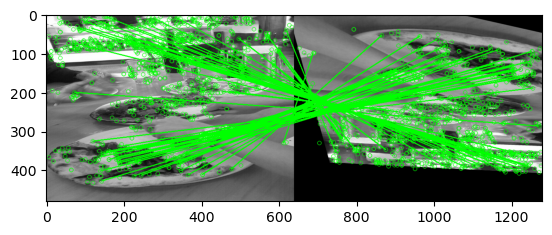

In [56]:
partial_assignment_matrix = batch["partial_assignment_matrix"]

print(partial_assignment_matrix[0])
print(torch.sum(partial_assignment_matrix[0][:-1, :-1]))

plt.imshow(
    visualize_matches(
        batch["image_original"][0],
        batch["image_novel"][0],
        batch["keypoints_original"][0],
        batch["keypoints_novel"][0],
        partial_assignment_matrix[0],
    )
)